In [39]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [40]:
# tf.debugging.set_log_device_placement(True)

In [41]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Flatten, Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import TensorBoard
from matplotlib import pyplot as plt
import numpy as np
import keras
from keras import backend as K

In [42]:
sess = tf.compat.v1.Session()

In [43]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0

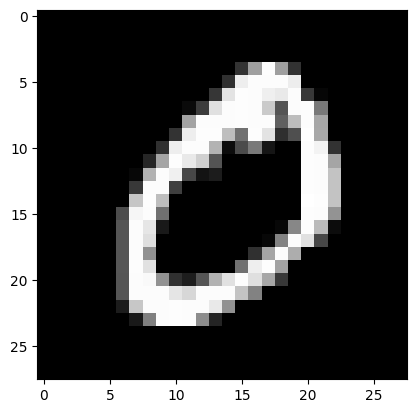

In [44]:
plt.imshow(x_train[1], cmap="gray")
plt.show()

In [45]:
input_dim = 28 * 28
hidden_dim = 32
latent_dim = 2

In [46]:
def sampling(args):
    z_mean, z_std = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
    return z_mean + K.exp(z_std) * epsilon

In [47]:
img = Input(shape=(input_dim,))
h = Dense(hidden_dim, activation='relu')(img)
z_mean = Dense(latent_dim)(h)
z_std = Dense(latent_dim)(h)

In [48]:
z = Lambda(sampling)([z_mean, z_std])

In [ ]:
encoder = Model(img, [z_mean, z_std, z], name='encoder')

In [49]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(hidden_dim, activation='relu')(latent_inputs)
outputs = Dense(input_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

In [ ]:
outputs = decoder(encoder(img)[2])
vae = Model(img, outputs, name='vae')

In [50]:
reconstruction_loss = keras.losses.binary_crossentropy(img, outputs)
reconstruction_loss *= input_dim
kl_loss = 1 + z_std - K.square(z_mean) - K.exp(z_std)
kl_loss = -0.5 * K.sum(kl_loss, axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [51]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train, epochs=100, batch_size=32, validation_data=(x_test, x_test), callbacks=[TensorBoard(log_dir='../logs/vae_autoencoder_logs')])

Epoch 1/100
1875/1875 [==============================] - 25s 10ms/step - loss: 193.6235 - val_loss: 172.1339
Epoch 2/100
1875/1875 [==============================] - 17s 9ms/step - loss: 169.4034 - val_loss: 166.8161
Epoch 3/100
1875/1875 [==============================] - 18s 9ms/step - loss: 165.1633 - val_loss: 163.7283
Epoch 4/100
1875/1875 [==============================] - 18s 10ms/step - loss: 162.7053 - val_loss: 162.0203
Epoch 5/100
1875/1875 [==============================] - 18s 10ms/step - loss: 161.0503 - val_loss: 160.9525
Epoch 6/100
1875/1875 [==============================] - 18s 10ms/step - loss: 159.9265 - val_loss: 159.7408
Epoch 7/100
1875/1875 [==============================] - 18s 10ms/step - loss: 159.0494 - val_loss: 158.9592
Epoch 8/100
1875/1875 [==============================] - 18s 10ms/step - loss: 158.3185 - val_loss: 158.2699
Epoch 9/100
1875/1875 [==============================] - 18s 10ms/step - loss: 157.6552 - val_loss: 157.5843
Epoch 10/100
1875/187

In [64]:
encoder.save('../models/vae_autoencoders/encoder_model')
vae.save('../models/vae_autoencoders/vae_model')

INFO:tensorflow:Assets written to: ../models/vae_autoencoders/encoder_model\assets
INFO:tensorflow:Assets written to: ../models/vae_autoencoders/vae_model\assets


313/313 [==============================] - 1s 2ms/step
(3, 10000, 2) (3, 10000) (10000,) (10000,)


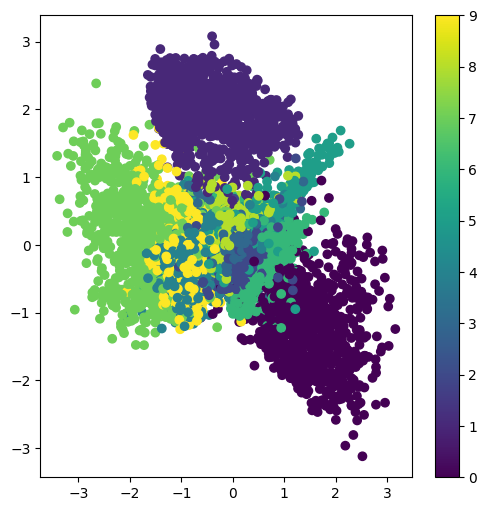

In [62]:
x_test_encoded = np.array(encoder.predict(x_test, batch_size=32))
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[2, :, 0], x_test_encoded[2, :, 1], c=y_test)
plt.colorbar()
plt.show()

1/1 [==============================] - 0s 21ms/step


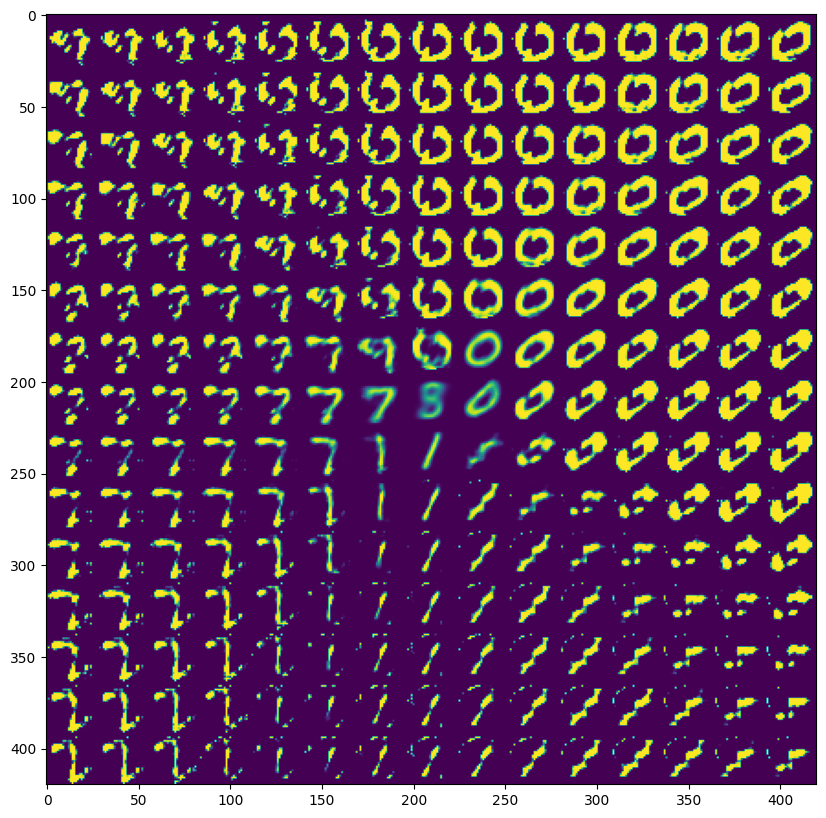

In [63]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()